<a href="https://colab.research.google.com/github/SalarShafiee/ML-Projects/blob/main/nutrition%205k%20novel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead"

Streaming output truncated to the last 5000 lines.
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711083/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711083/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711083/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711115/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711115/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711115/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711154/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1565711154/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_datase

KeyboardInterrupt: 

In [24]:
!mkdir -p nutrition5k_data/scripts
!mkdir -p nutrition5k_data/metadata
!mkdir -p nutrition5k_data/dish_ids

In [28]:
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/scripts/" nutrition5k_data/scripts
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/" nutrition5k_data/metadata
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/" nutrition5k_data/dish_ids

Copying gs://nutrition5k_dataset/nutrition5k_dataset/scripts/compute_eval_statistics.py...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/scripts/extract_frames.sh...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/scripts/extract_frames_sampled.sh...
/ [3/3 files][  2.7 KiB/  2.7 KiB] 100% Done                                    
Operation completed over 3 objects/2.7 KiB.                                      
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv...
/ [3/3 files][  2.2 MiB/  2.2 MiB] 100% Done                                    
Operation completed over 3 objects/2.2 MiB.                                      
Copying gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt...
Copying gs://nutrition5k_dataset/nutrition5k_dataset

In [33]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# data preprocessing
import os

'''
We are training the model based on the overhead images inside of side-angle videos which are more complex and low quality.
Since the original dataset provides the split of the training/testing set based on the images (side-angle videos and overhead), we need to find all dish ids that are present in the overhead images.
Therefore, we first find the ids in the training/testing set and then find the intersection of these ids with the overhead images.

'''

nutrition5k_path = "/content/nutrition5k_dataset"
nutrition5k_overhead_path = "/content/nutrition5k_dataset/imagery/realsense_overhead"
train_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_train_ids.txt')
test_dir = os.path.join(nutrition5k_path, 'dish_ids/splits/rgb_test_ids.txt')
original_labels = "/content/nutrition5k_dataset/metadata/metadata/dish_metadata_cafe1.csv"
ingredients_metadata = "/content/nutrition5k_dataset/metadata/metadata/ingredients_metadata.csv"

"""
realsense_overhead
    - image_index
        - depth_color.png
        - depth_raw.png
        - rgb.png


side_angles
    - image_index
        - frames_sampled30
            - camera_{}_frame_{}.png

metadata
    - dish_metadata_cafe1.csv
        - dish_id, dish_name, calories, mass, fat, carb, protein, ingredients content
    - dish_metadata_cafe2.csv
    - ingredients_metadata.csv
"""

overhead_ids = set()
for file in os.listdir(nutrition5k_overhead_path):
    overhead_ids.add(file)

print('Number of unique overhead ids: ', len(overhead_ids))

train_dis = set()
test_dis = set()
with open(train_dir, 'r') as f:
    train_list = f.readlines()
    for i in train_list:
        train_dis.add(i.strip())

with open(test_dir, 'r') as f:
    test_list = f.readlines()
    for i in test_list:
        test_dis.add(i.strip())

print('Valid Training Samples:', len(train_dis.intersection(overhead_ids)))
print('Intersection (Test and Overhead):', len(test_dis.intersection(overhead_ids)))

valid_overhead_ids = train_dis.intersection(overhead_ids).union(test_dis.intersection(overhead_ids))
print('Number of valid overhead ids:', len(valid_overhead_ids))

labels_dict = {}
with open(original_labels, 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip().split(',')
        if line[0] in valid_overhead_ids:
            labels_dict[line[0]] = line[1:]

print('Number of valid overhead ids with labels:', len(labels_dict))
## Example of labels_dict
print('Example of labels_dict:', labels_dict['dish_1562699612'])

Number of unique overhead ids:  3490
Valid Training Samples: 2755
Intersection (Test and Overhead): 507
Number of valid overhead ids: 3262
Number of valid overhead ids with labels: 3262
Example of labels_dict: ['98.391266', '74.000000', '2.671786', '15.661942', '2.793359', 'ingr_0000000023', 'brown rice', '22.000000', '24.42', '0.198', '5.06', '0.572', 'ingr_0000000377', 'quinoa', '50.485435', '60.582522', '0.959223265', '10.60194135', '2.22135914', 'ingr_0000000161', 'olive oil', '1.514563', '13.38873692', '1.514563', '0.0', '0.0']


In [43]:
# Reconstruction of the dataset (Including Images and Labels)
import time

start_time = time.time()
print('Start Reconstruction...')

# create a new dataset containing only the valid overhead ids
data_path = "/content/nutrition5k_reconstructed"
if not os.path.exists(data_path):
    os.makedirs(data_path)

image_path = os.path.join(data_path, 'images')
if not os.path.exists(image_path):
    os.makedirs(image_path)

index = 0 # Correct the indentation of this line
for i in valid_overhead_ids:
    curr_overhead_image_path = os.path.join(nutrition5k_overhead_path, i)

    for overhead_pics in os.listdir(curr_overhead_image_path):
        if overhead_pics != 'rgb.png':
            continue
        # print overhead pics's absolute path
        abs_address = os.path.join(curr_overhead_image_path, overhead_pics)
        os.system('cp ' + abs_address + ' ' + os.path.join(image_path, f'{i}.jpeg')) # Correct the indentation of this line
        index += 1 # Correct the indentation of this line

print('Number of images:', index)

# reconstruct the labels and metadata # Correct the indentation of this line
metadata_path = os.path.join(data_path, 'metadata') # Correct the indentation of this line
if not os.path.exists(metadata_path): # Correct the indentation of this line
    os.makedirs(metadata_path) # Correct the indentation of this line

# Reconstruct the training and testing metadata # Correct the indentation of this line
train_ids_path = os.path.join(metadata_path, 'train_ids.csv') # Correct the indentation of this line
test_ids_path = os.path.join(metadata_path, 'test_ids.csv') # Correct the indentation of this line

index = 0 # Correct the indentation of this line
with open(train_ids_path, 'w') as f: # Correct the indentation of this line
    for i in train_dis.intersection(valid_overhead_ids): # Correct the indentation of this line
        f.write(i + '\n') # Correct the indentation of this line
        index += 1 # Correct the indentation of this line
print('Number of training ids:', index) # Correct the indentation of this line

index = 0 # Correct the indentation of this line
with open(test_ids_path, 'w') as f: # Correct the indentation of this line
    for i in test_dis.intersection(valid_overhead_ids): # Correct the indentation of this line
        f.write(i + '\n') # Correct the indentation of this line
        index += 1 # Correct the indentation of this line

print('Number of testing ids:', index) # Correct the indentation of this line

# Reconstruct the labels # Correct the indentation of this line
ingr_list = [] # Correct the indentation of this line
for ids in valid_overhead_ids: # Correct the indentation of this line
    data = labels_dict[ids] # Correct the indentation of this line
    for indx, i in enumerate(data[5:]): # Correct the indentation of this line
        if i.startswith('ingr_0000000'): # Correct the indentation of this line
            # take non-zero part of the string from -1 position # Correct the indentation of this line
            ingr = data[5 + indx + 1] # Correct the indentation of this line
            if ingr == '': # Correct the indentation of this line
                print('Empty ingredient:', ids) # Correct the indentation of this line
            ingr_list.append(ingr) if ingr not in ingr_list else ingr_list # Correct the indentation of this line

print('Number of unique ingredients:', len(ingr_list)) # Correct the indentation of this line

labels_path = os.path.join(data_path, 'labels') # Correct the indentation of this line
if not os.path.exists(labels_path): # Correct the indentation of this line
    os.makedirs(labels_path) # Correct the indentation of this line

index = 0 # Correct the indentation of this line
labels_file = os.path.join(labels_path, 'labels.csv') # Correct the indentation of this line
with open(labels_file, 'w') as f: # Correct the indentation of this line
    caption_str = 'id,calories,mass,fat,carb,protein,' # Correct the indentation of this line
    for ingr in ingr_list: # Correct the indentation of this line
        caption_str += ingr + ',' # Correct the indentation of this line

    f.write(caption_str[:-1] + '\n') # Correct the indentation of this line

    for ids in valid_overhead_ids: # Correct the indentation of this line
        data = labels_dict[ids] # Correct the indentation of this line
        # take only the first 5 columns (calories, mass, fat, carb, protein) # Correct the indentation of this line
        nutritional_facts = data[:5] # Correct the indentation of this line
        ingredients = [] # Correct the indentation of this line
        for indx, i in enumerate(data[5:]): # Correct the indentation of this line
            if i.startswith('ingr_0000000'): # Correct the indentation of this line
                # take non-zero part of the string from -1 position # Correct the indentation of this line
                ingr = data[5 + indx + 1] # Correct the indentation of this line
                ingr_mass = data[5 + indx + 2] # Correct the indentation of this line
                ingredients.append((ingr, ingr_mass)) # Correct the indentation of this line

        ingr_index = [] # Correct the indentation of this line
        for ingr in ingr_list: # Correct the indentation of this line
            for i in ingredients: # Correct the indentation of this line
                if ingr == i[0]: # Correct the indentation of this line
                    ingr_index.append(i[1]) # Correct the indentation of this line
                    break # Correct the indentation of this line

            else: # Correct the indentation of this line
                ingr_index.append(str(float(0))) # Correct the indentation of this line

        f.write(ids + ',' + ','.join(nutritional_facts) + ',' + ','.join(ingr_index) + '\n') # Correct the indentation of this line
        index += 1 # Correct the indentation of this line

print('Number of labels:', index) # Correct the indentation of this line

end_time = time.time() # Correct the indentation of this line
print('Data preprocessing done!') # Correct the indentation of this line
print('Time taken to copy images: ', end_time - start_time) # Correct the indentation of this line
print('Data stored in: ', data_path) # Correct the indentation of this line

Start Reconstruction...
Number of images: 3262
Number of training ids: 2755
Number of testing ids: 507
Empty ingredient: dish_1568666357
Number of unique ingredients: 199
Number of labels: 3262
Data preprocessing done!
Time taken to copy images:  27.966203689575195
Data stored in:  /content/nutrition5k_reconstructed


In [44]:
# Sanity Check
df = pd.read_csv(labels_file, sep=',')

print('Number of ids in both the training and testing set:', len(train_dis.intersection(test_dis)))

print()

df

Number of ids in both the training and testing set: 0



,id,calories,mass,fat,carb,protein,salt,chard,olive oil,mustard greens,...,wheat bread,orange with peel,chicken salad,tempeh,mozzarella cheese,syrup,Unnamed: 201,bread,chilaquiles,plate only
0,dish_1567628099,127.493019,132.0,7.445891,13.796238,3.849013,0.212828,29.5,6.810496,25.539358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dish_1567789256,792.218384,319.0,64.688202,9.403199,41.403400,0.400000,0.0,12.799999,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dish_1566414754,755.496277,533.0,33.023949,28.348515,98.857841,2.186674,0.0,4.489071,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dish_1560887408,324.520020,122.0,11.834001,40.260002,13.420000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dish_1562008476,120.505836,120.0,6.163932,6.287506,10.764524,0.305534,0.0,0.720292,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,dish_1567525712,510.544769,184.0,40.461380,32.977020,6.916218,0.490909,0.0,15.709090,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3258,dish_1558031394,237.410004,318.0,0.521000,55.475998,4.230000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3259,dish_1559060055,26.730001,81.0,0.243000,6.480000,0.567000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3260,dish_1562173267,409.570007,171.0,27.119999,18.188000,21.401001,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,0.0


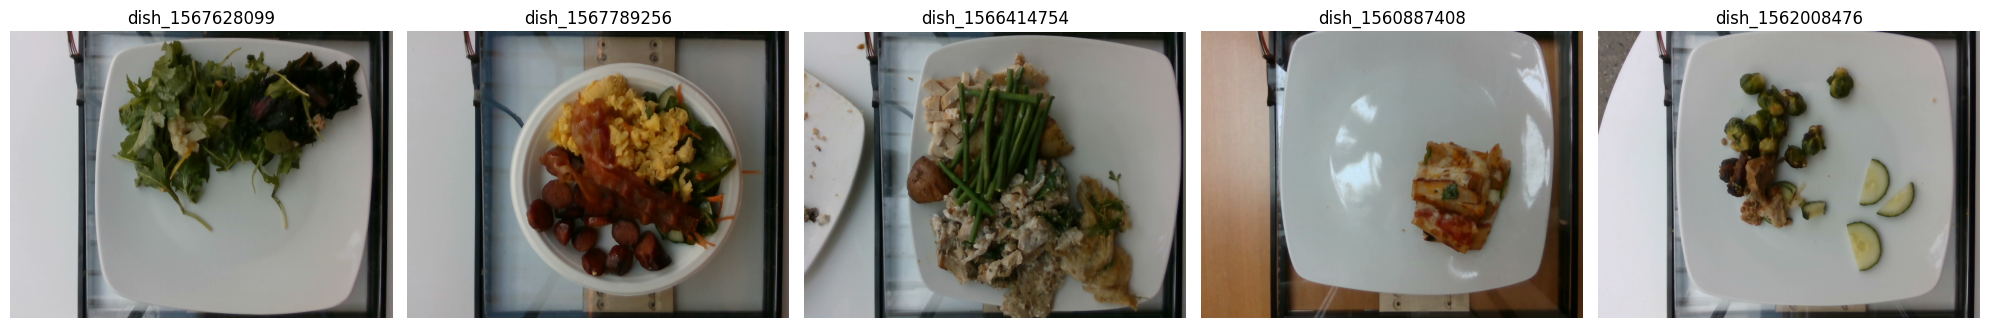

                id    calories   mass        fat       carb    protein  \
0  dish_1567628099  127.493019  132.0   7.445891  13.796238   3.849013   
1  dish_1567789256  792.218384  319.0  64.688202   9.403199  41.403400   
2  dish_1566414754  755.496277  533.0  33.023949  28.348515  98.857841   
3  dish_1560887408  324.520020  122.0  11.834001  40.260002  13.420000   
4  dish_1562008476  120.505836  120.0   6.163932   6.287506  10.764524   

       salt  chard  olive oil  mustard greens  ...  wheat bread  \
0  0.212828   29.5   6.810496       25.539358  ...          0.0   
1  0.400000    0.0  12.799999        0.000000  ...          0.0   
2  2.186674    0.0   4.489071        0.000000  ...          0.0   
3  0.000000    0.0   0.000000        0.000000  ...          0.0   
4  0.305534    0.0   0.720292        0.000000  ...          0.0   

   orange with peel  chicken salad  tempeh  mozzarella cheese  syrup  \
0               0.0            0.0     0.0                0.0    0.0   
1       

In [45]:
import matplotlib.pyplot as plt
from PIL import Image


# this function will plot images in the form of a grid with 1 row and 5 columns where images are placed in the first batch
def plotImages(images_arr, ids):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    # show ids as well
    for img, ax, id in zip(images_arr, axes, ids):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(id)
    plt.tight_layout()
    plt.show()

# Displaying the first 5 images from the dataset
images = [Image.open(os.path.join(image_path, f'{i}.jpeg')) for i in df['id'][:5]]
ids = df['id'][:5]
plotImages(images, ids)

# Displaying the first 5 labels from the dataset
print(df.head())

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
from torchvision.models import (
    inception_v3, Inception_V3_Weights,
    vit_b_16, ViT_B_16_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights,
    convnext_small, ConvNeXt_Small_Weights,
    resnet50, ResNet50_Weights
    )

############################################################################################################
'''
BackBones
- InceptionV3
- Vision Transformer (ViT)
- EfficientNet
- ConvNeXt
- ResNet50
'''
class ResNetBackbone(nn.Module):
    def __init__(self, pretrained = True):
        super().__init__()
        # Load ResNet50 with pre-trained weights
        if pretrained:
            self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        else:
            self.backbone = resnet50(weights=None)
        self.backbone.fc = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # Forward pass through ResNet50 backbone
        return self.backbone(x)

class ConvNextBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Load ConvNeXt with pre-trained weights
        if pretrained:
            self.backbone = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
        else:
            self.backbone = convnext_small(weights=None) # input size: 3x224x224
        self.backbone.classifier = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # Forward pass through ConvNeXt backbone
        features = self.backbone(x)
        output_features = features.view(features.size(0), -1)
        return output_features

class InceptionV3(nn.Module):
    def __init__(self, pretrained = True):
        """
        Args:
            weights: Pre-trained weights to use for the InceptionV3 model. Use `None` for no pre-training.
        """
        super().__init__()
        # Load the InceptionV3 model with specified weights
        if pretrained:
            self.backbone = inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
        else:
            self.backbone = inception_v3(weights=None, aux_logits=True)
        self.backbone.fc = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # When aux_logits=True, the output is a tuple: (main_output, aux_output)
        x = self.backbone(x)
        return x[0] if isinstance(x, tuple) else x

class ViTBackbone(nn.Module):
    def __init__(self, pretrained = True):
        """
        Args:
            weights: Pre-trained weights to use for the ViT model. Use `None` for no pre-training.
        """
        super().__init__()
        # Load the Vision Transformer with pretrained weights
        if pretrained:
            self.backbone = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        else:
            self.backbone = vit_b_16(weights=None)
        self.backbone.heads = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # Forward pass through the ViT backbone
        x = self.backbone(x)
        return x

class EfficientNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Load EfficientNet with pre-trained weights
        if pretrained:
            self.backbone = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
        else:
            self.backbone = efficientnet_v2_m(weights=None)
        self.backbone.classifier = nn.Identity()  # Remove the classification head

    def forward(self, x):
        # Forward pass through EfficientNet backbone
        return self.backbone(x)

############################################################################################################
'''
For Ingredient + Mass Prediction (Regression)
- Our Implementation of Mass Prediction Model
    - BaselineModel: CNN-based model for mass prediction
    - IngrPredModel: Pretrained backbone-based + LSTM-based model for ingredient prediction
    - NutriFusionNet: Stacking Attention Encoder-Decoder Network for ingredient prediction
'''

class BaselineModel(nn.Module):
    def __init__(self, num_ingr = 199, hidden_dim=512):
        super(BaselineModel, self).__init__()
        # Define convolutional layers to extract spatial features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.bn5 = nn.BatchNorm2d(512)

        # flatten the output from conv layers for FC
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.mass_prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_ingr),
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Pass input through convolutional layers with batch normalization and pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)  # Output: (batch, 64, 112, 112)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)  # Output: (batch, 128, 56, 56)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)  # Output: (batch, 256, 28, 28)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)  # Output: (batch, 512, 14, 14)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2, 2)  # Output: (batch, 512, 7, 7)

        # Flatten the output from conv layers for FC
        x = x.view(batch_size, -1)  # Output: (batch, 512 * 7 * 7)

        # Pass through the fully connected layers
        x = self.fc1(x)  # Output: (batch, hidden_dim)

        # Pass through task-specific heads
        outputs = self.mass_prediction(x)

        return outputs

class IngrPredModel(nn.Module):
    def __init__(self, num_ingr = 199, backbone = 'resnet', pretrained = True, hidden_dim = 512, dropout_rate=0.3):
        super(IngrPredModel, self).__init__()

        # Use the specified backbone
        self.backbone_type = backbone
        if backbone == "vit":
            self.backbone = ViTBackbone(pretrained)
            input_size = 768
        elif backbone == "convnx":
            self.backbone = ConvNextBackbone(pretrained)
            input_size = 768
        elif backbone == "resnet":
            self.backbone = ResNetBackbone(pretrained)
            input_size = 2048
        elif backbone == "effnet":
            self.backbone = EfficientNetBackbone(pretrained)
            input_size = 1280
        elif backbone == "incept":
            self.backbone = InceptionV3(pretrained)
            input_size = 2048
        else:
            raise ValueError(f"Invalid backbone {backbone}")

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=0.5)

        # Custom fully connected layers for regression
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
        )

        self.mass_prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_ingr),
        )

    def forward(self, x):
        batch_size = x.size(0)
        # Forward pass through ViT backbone
        x = self.backbone(x)  # Output: [batch_size, input_size]

        x = x.view(batch_size, 1, -1)  # Output: (batch, 1, input_size)
        # Pass through LSTM layer
        lstm_out, _ = self.lstm(x)

        # Extract the output from the LSTM
        lstm_out = lstm_out[:, -1, :]  # Output: (batch, hidden_dim)

        x = self.fc_layers(lstm_out)

        # Task-specific head
        outputs = self.mass_prediction(x)

        return outputs

############## Multimodal Encoder-Decoder Network ##########################
class IngredientFeatureExtractorV2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, lstm_layers, extraction_mode="lstm"):
        super(IngredientFeatureExtractorV2, self).__init__()
        # 300-dimensional GloVe embeddings for ingredients
        # 768-dimensional BERT embeddings for ingredients
        # Transformer Encoder
        assert extraction_mode in ["lstm", "lstm_dropout", "global_pooling", "attn_pooling", "max_pooling"], f"Invalid extraction mode {extraction_mode}"
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm_layers = lstm_layers
        self.extraction_mode = extraction_mode

        if extraction_mode == "lstm":
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)
        elif extraction_mode == "lstm_dropout":
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=0.3)
        elif extraction_mode == "global_pooling" or extraction_mode == "max_pooling":
            self.fc_layers = nn.Sequential(
                nn.Linear(embedding_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),
            )
        elif extraction_mode == "attn_pooling":
            self.query  = nn.Linear(embedding_dim, hidden_dim)
            self.key = nn.Linear(embedding_dim, hidden_dim)
            self.value = nn.Linear(embedding_dim, hidden_dim)

            self.softmax = nn.Softmax(dim=1)
            self.dropout = nn.Dropout(0.3)

    def forward(self, ingredient_embeddings):
        # Project input embeddings to hidden_dim
        if self.extraction_mode == "lstm" or self.extraction_mode == "lstm_dropout":
            # ingredient_embeddings: (num_ingr, embedding_dim) as each image will have the same candidate ingredients
            # Pass through LSTM
            lstm_out, _ = self.lstm(ingredient_embeddings)  # Output: (batch, 1, hidden_dim)

            # Extract the output from the LSTM
            ingr_feature = lstm_out[:, -1, :]  # Output: (batch, hidden_dim)

            return ingr_feature

        elif self.extraction_mode == "global_pooling":
            # Pass through fully connected layers
            ingr_feature = self.fc_layers(ingredient_embeddings)

            ingr_feature = ingr_feature.mean(dim=1)  # Output: (batch, hidden_dim)

            return ingr_feature

        elif self.extraction_mode == "max_pooling":
            # Pass through fully connected layers
            ingr_feature = self.fc_layers(ingredient_embeddings)

            ingr_feature = ingr_feature.max(dim=1)[0]

            return ingr_feature

        elif self.extraction_mode == "attn_pooling":
            queries = self.query(ingredient_embeddings)
            keys = self.key(ingredient_embeddings)
            values = self.value(ingredient_embeddings)

            # Calculate attention scores
            attention_scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.hidden_dim ** 0.5) # Output: (batch, num_ingr, num_ingr)

            # Apply softmax to get attention weights
            attention_weights = self.softmax(attention_scores)  # Output: (batch, num_ingr, num_ingr)
            attention_weights = self.dropout(attention_weights) # Output: (batch, num_ingr, num_ingr)

            # Aggregate the values using the attention weights
            ingr_feature = torch.bmm(attention_weights, values)  # Output: (batch, num_ingr, hidden_dim)
            ingr_feature = ingr_feature.mean(dim=1)  # Output: (batch, hidden_dim)

            return ingr_feature

class ImageFeatureExtractor(nn.Module):
    def __init__(self, backbone='resnet', pretrained=True, hidden_dim=256):
        super(ImageFeatureExtractor, self).__init__()

        # Use the specified backbone
        self.backbone_type = backbone
        if backbone == "vit":
            self.backbone = ViTBackbone(pretrained)
            input_size = 768
        elif backbone == "convnx":
            self.backbone = ConvNextBackbone(pretrained)
            input_size = 768
        elif backbone == "resnet":
            self.backbone = ResNetBackbone(pretrained)
            input_size = 2048
        elif backbone == "effnet":
            self.backbone = EfficientNetBackbone(pretrained)
            input_size = 1280
        elif backbone == "incept":
            self.backbone = InceptionV3(pretrained)
            input_size = 2048
        else:
            raise ValueError(f"Invalid backbone {backbone}")

        self.image_fc = nn.Linear(input_size, hidden_dim)

    def forward(self, images):
        # images: (batch_size, 3, 224, 224)
        image_features = self.backbone(images) # (batch_size, 768)
        image_features = self.image_fc(image_features) # (batch_size, hidden_dim)
        return image_features

class AttentionEncoderDecoder(nn.Module):
    def __init__(self, num_heads, d_model, dropout=0.3, epsilon=1e-6):
        super(AttentionEncoderDecoder, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout = dropout
        self.epsilon = epsilon

        # Encoder layers (for ingredient features)
        # self-attention
        self.ingredients_sa = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
        self.ingredients_sa_normalized = nn.LayerNorm(d_model, eps=epsilon)
        self.ingredients_aligned = nn.Linear(d_model, d_model)
        self.ingredients_encoded = nn.LayerNorm(d_model, eps=epsilon)

        # Decoder layers (for dish image features)
        # guided attention + self-attention
        self.dish_image_ga = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
        self.dish_image_ga_normalized = nn.LayerNorm(d_model, eps=epsilon)

        # self-attention to model spatial relationships among dish image regions
        self.dish_image_sa = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
        self.dish_image_sa_normalized = nn.LayerNorm(d_model, eps=epsilon)
        self.dish_image_aligned = nn.Linear(d_model, d_model)
        self.dish_image_decoded = nn.LayerNorm(d_model, eps=epsilon)

    def forward(self, ingredients, dish_image):
        # Encoder: Ingredients Self-Attention
        ingredients_sa, _ = self.ingredients_sa(ingredients, ingredients, ingredients) # (batch_size, d_model)
        ingredients_sa = self.ingredients_sa_normalized(ingredients_sa + ingredients) # (batch_size, d_model)
        ingredients_aligned = F.relu(self.ingredients_aligned(ingredients_sa)) # (batch_size, dff)
        ingredients_encoded = self.ingredients_encoded(ingredients_sa + ingredients_aligned) # (batch_size, d_model)

        # Decoder: Dish Image Guided Attention + Self-Attention
        dish_image_ga, _ = self.dish_image_ga(dish_image, ingredients_encoded, ingredients_encoded)
        dish_image_ga = self.dish_image_ga_normalized(dish_image_ga + dish_image)
        dish_image_sa, _ = self.dish_image_sa(dish_image_ga, dish_image_ga, dish_image_ga)
        dish_image_sa = self.dish_image_sa_normalized(dish_image_sa + dish_image_ga)
        dish_image_aligned = F.relu(self.dish_image_aligned(dish_image_sa))
        dish_image_decoded = self.dish_image_decoded(dish_image_sa + dish_image_aligned)

        return ingredients_encoded, dish_image_decoded

############################################################################################################
'''
Stacking Attention Encoder-Decoder Network
'''

class SMEDA(nn.Module):
    def __init__(self, num_heads, d_model, dropout=0.3, num_layers=3, epsilon=1e-6):
        super(SMEDA, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.dropout = dropout
        self.epsilon = epsilon
        self.num_layers = num_layers

        # Define stacks of Ingredient Encoders and Dish Decoders
        self.ingredient_encoders = nn.ModuleList([
            nn.ModuleDict({
                'self_attention': nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout),
                'self_attention_norm': nn.LayerNorm(d_model, eps=epsilon),
                'alignment': nn.Linear(d_model, d_model),
                'encoding': nn.LayerNorm(d_model, eps=epsilon),
            })
            for _ in range(num_layers)
        ])

        self.dish_image_decoders = nn.ModuleList([
            nn.ModuleDict({
                'guided_attention': nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout),
                'guided_attention_norm': nn.LayerNorm(d_model, eps=epsilon),
                'self_attention': nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout),
                'self_attention_norm': nn.LayerNorm(d_model, eps=epsilon),
                'alignment': nn.Linear(d_model, d_model),
                'decoding': nn.LayerNorm(d_model, eps=epsilon),
            })
            for _ in range(num_layers)
        ])

    def forward(self, ingredients, dish_image):
        # Encoder: Ingredients Self-Attention

        for i in range(self.num_layers):
            # Ingredient Encoding
            ingr_self_attn, _ = self.ingredient_encoders[i]['self_attention'](ingredients, ingredients, ingredients)
            ingr_self_attn = self.ingredient_encoders[i]['self_attention_norm'](ingr_self_attn + ingredients)
            ingr_aligned = F.relu(self.ingredient_encoders[i]['alignment'](ingr_self_attn))
            ingr_encoded = self.ingredient_encoders[i]['encoding'](ingr_self_attn + ingr_aligned) # (num_ingr, d_model)

            # Dish Image Decoding with Cross-Attention
            dish_guided_attn, _ = self.dish_image_decoders[i]['guided_attention'](dish_image, ingr_encoded, ingr_encoded)
            dish_guided_attn = self.dish_image_decoders[i]['guided_attention_norm'](dish_guided_attn + dish_image)

            # Dish Image self-attention
            dish_self_attn, _ = self.dish_image_decoders[i]['self_attention'](dish_guided_attn, dish_guided_attn, dish_guided_attn)
            dish_self_attn = self.dish_image_decoders[i]['self_attention_norm'](dish_self_attn + dish_guided_attn)
            dish_aligned = F.relu(self.dish_image_decoders[i]['alignment'](dish_self_attn))
            dish_decoded = self.dish_image_decoders[i]['decoding'](dish_self_attn + dish_aligned) # (batch_size, d_model)

            # Update the dish image features for the next layer
            dish_image = dish_decoded

            # Update the ingredient features for the next layer
            ingredients = ingr_encoded


        return ingr_encoded, dish_decoded

class NutriFusionNet(nn.Module):
    def __init__(self, num_ingr = 199, backbone = "resnet", ingredient_embedding = None, pretrained = True, hidden_dim = 512, lstm_layers = 1, num_heads = 8, dropout = 0.3, epsilon = 1e-6, num_layers = 2, extraction_mode="lstm"):
        super(NutriFusionNet, self).__init__()

        self.ingredient_embedding = ingredient_embedding

        self.ingredient_extractor = IngredientFeatureExtractorV2(embedding_dim=ingredient_embedding.size(1), hidden_dim=hidden_dim, lstm_layers=lstm_layers, extraction_mode=extraction_mode)
        self.image_extractor = ImageFeatureExtractor(backbone=backbone, pretrained = pretrained, hidden_dim=hidden_dim)

        if num_layers == 1:
            self.attn_enc_dec = AttentionEncoderDecoder(num_heads, hidden_dim, dropout, epsilon)
        elif num_layers > 1:
            self.attn_enc_dec = SMEDA(num_heads, hidden_dim, dropout, num_layers, epsilon)
        else:
            raise ValueError(f"Invalid number of layers {num_layers}")

        self.fusion_layer = nn.Linear(hidden_dim * 2, hidden_dim)

        # Mass prediction
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_ingr),
        )

    def forward(self, images):
        # Extract features
        ingredient_embeddings = self.ingredient_embedding.unsqueeze(0).repeat(images.size(0), 1, 1)
        ingredients_features = self.ingredient_extractor(ingredient_embeddings)
        dish_image_features = self.image_extractor(images)

        # Attention Encoder-Decoder
        ingredients_encoded, dish_image_decoded = self.attn_enc_dec(ingredients_features, dish_image_features)

        # Global pooling
        # Multimodal fusion
        fused_features = torch.cat([ingredients_encoded, dish_image_decoded], dim=1) # (batch_size, d_model * 2)
        fused_features = self.fusion_layer(fused_features) # (batch_size, d_model)

        # Mass prediction
        prediction = self.mlp(fused_features) # (batch_size, num_ingr)
        return prediction

############################################################################################################
if __name__ == "__main__":
    x = torch.randn(16, 3, 224, 224) # For ConvLSTM model and ViT model
    num_ingr = 199

    embed = torch.randn(num_ingr, 768) # Assume 768-dimensional embeddings
    tasks = ["calories", "mass", "fat", "carb", "protein"]

    # # test the ingredient feature extractor
    # print("\nTesting the IngredientFeatureExtractorV2")
    test_embed = embed.unsqueeze(0).repeat(16, 1, 1)

    ingr_extractor = IngredientFeatureExtractorV2(embedding_dim=768, hidden_dim=512, lstm_layers=2, extraction_mode="lstm")
    output = ingr_extractor(test_embed)
    print(f"Output shape: {output.shape}") # (batch_size, hidden_dim)

    ingr_extractor = IngredientFeatureExtractorV2(embedding_dim=768, hidden_dim=512, lstm_layers=2, extraction_mode="lstm_dropout")
    output = ingr_extractor(test_embed)
    print(f"Output shape: {output.shape}") # (batch_size, hidden_dim)

    ingr_extractor = IngredientFeatureExtractorV2(embedding_dim=768, hidden_dim=512, lstm_layers=2, extraction_mode="attn_pooling")
    output = ingr_extractor(test_embed)
    print(f"Output shape: {output.shape}") # (batch_size, hidden_dim)

    ingr_extractor = IngredientFeatureExtractorV2(embedding_dim=768, hidden_dim=512, lstm_layers=2, extraction_mode="global_pooling")
    output = ingr_extractor(test_embed)
    print(f"Output shape: {output.shape}") # (batch_size, hidden_dim)

    ingr_extractor = IngredientFeatureExtractorV2(embedding_dim=768, hidden_dim=512, lstm_layers=2, extraction_mode="max_pooling")
    output = ingr_extractor(test_embed)
    print(f"Output shape: {output.shape}") # (batch_size, hidden_dim)

    print("\nTesting the BaselineModel")
    test_model = BaselineModel(num_ingr)
    output = test_model(x)
    print(f"Output shape: {output.shape}")

    print("\nTesting the IngrModel")
    model = IngrPredModel(num_ingr, "vit", pretrained=False)
    output = model(x)
    print(f"Output shape: {output.shape}")

    print("\nTesting the NutriFusionNet")
    model = NutriFusionNet(num_ingr, "vit", embed, hidden_dim=512)
    output = model(x)
    print(f"Output shape: {output.shape}")

    print("\nAll tests passed!")

Output shape: torch.Size([16, 512])
Output shape: torch.Size([16, 512])
Output shape: torch.Size([16, 512])
Output shape: torch.Size([16, 512])
Output shape: torch.Size([16, 512])

Testing the BaselineModel
Output shape: torch.Size([16, 199])

Testing the IngrModel
Output shape: torch.Size([16, 199])

Testing the NutriFusionNet


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 54.2MB/s]


Output shape: torch.Size([16, 199])

All tests passed!
